# EPFL - Statistical learning (MATH-412) - Week 4
## Model selection methods

In [29]:
import os
import numpy as np
import utils as ut
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error as mse
import sklearn.model_selection as model_selection
import csv

First, we load the 'bodyfat.csv' dataset:

In [6]:
# Load the dataset
input_file = os.path.join(os.getcwd(), 'data', 'bodyfat.csv')
file = open(input_file, 'rt')
reader = csv.reader(file, delimiter=';')
bodyfat = np.array([row for row in reader])

# Extract the header
header = bodyfat[0,:]

# Remove rows 2 and 4
col_to_del = [1, 3]
bodyfat = np.delete(bodyfat[1:,:], col_to_del, axis=0)

# Extract targets and features
targets = bodyfat[:,0].astype(np.float64)
features = np.array(bodyfat[:,1:]).T.astype(np.float64)

We create a linear model using sklearn. Our objective is to find the most relevant number of features to use in the model.

In [11]:
# Linear model
linear_model = lm.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

1\. Perform best-subset selection, forward stepwise selection, backward stepwise selecttion for $k = 1, . . . , 13$. Plot the residual sum of squares of
the best models over $k$.

In [19]:
# Number of features considered for best subset selection
list_n_features = np.arange(1,13)

# Perform best subset selection, forward stepwise selection, backward stepwise selection
rss_bss = []
rss_fsw = []
rss_bsw = []
for n_features in list_n_features:
    best_model, best_index, error_bss = ut.best_subset_selection(model=linear_model, n_features=n_features, features=features, targets=targets)
    best_model, best_index, error_fsw = ut.forward_selection(model=linear_model, n_features=n_features, features=features,
                                                     targets=targets)
    bestmodel, best_index, error_bsw = ut.backward_selection(model=linear_model, n_features=n_features, features=features,
                                                 targets=targets)
    rss_bss.append(error_bss)
    rss_fsw.append(error_fsw)
    rss_bsw.append(error_bsw)

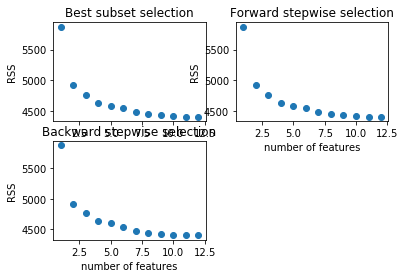

In [20]:
# Display the results
plt.subplot(221)
ax = plt.gca()
ax.scatter(list_n_features, rss_bss)
plt.xlabel('number of features')
plt.ylabel('RSS')
plt.title('Best subset selection')
plt.axis('tight')

plt.subplot(222)
ax = plt.gca()
ax.scatter(list_n_features, rss_fsw)
plt.xlabel('number of features')
plt.ylabel('RSS')
plt.title('Forward stepwise selection')
plt.axis('tight')

plt.subplot(223)
ax = plt.gca()
ax.scatter(list_n_features, rss_bsw[::-1])
plt.xlabel('number of features')
plt.ylabel('RSS')
plt.title('Backward stepwise selection')
plt.axis('tight')

plt.show()

We now create ridge and LASSO models using sklearn. We want to optimize the value of the regularization parameter using model selection algorithms.

In [22]:
# Create LASSO and ridge models
lasso = lm.Lasso(max_iter=1000, tol=1e-4, random_state=5)
ridge = lm.Ridge()

2\. Perform ridge and lasso regression for some sequences of λ.

In [25]:
# Fit Lasso and ridge for different values of the regularization parameter
list_alphas = np.logspace(-6, 6, 200)
rss_lasso = []
rss_ridge = []
coefs_lasso = []
coefs_ridge = []
for alpha in list_alphas:
    # Set the value of alpha
    lasso.set_params(alpha=alpha)
    ridge.set_params(alpha=alpha)

    # Fit the LASSO regression model
    lasso.fit(features.T, targets)
    coefs_lasso.append(lasso.coef_)

    # Prediction with LASSO
    predicted_target = lasso.predict(features.T)
    rss_lasso.append(ut.compute_RSS(orig=targets, pred=predicted_target))

    # Fit the ridge regression model
    ridge.fit(features.T, targets)
    coefs_ridge.append(ridge.coef_)

    # Prediction with ridge
    predicted_target_ridge = ridge.predict(features.T)
    rss_ridge.append(ut.compute_RSS(orig=targets, pred=predicted_target_ridge))


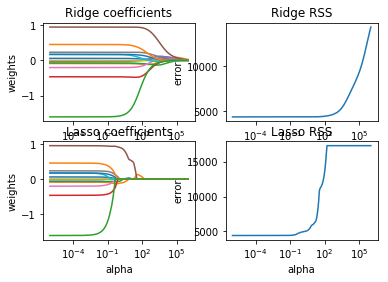

In [26]:
# Display the results
plt.subplot(221)
ax = plt.gca()
ax.plot(list_alphas, coefs_ridge)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients')
plt.axis('tight')

plt.subplot(222)
ax = plt.gca()
ax.plot(list_alphas, rss_ridge)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.title('Ridge RSS')
plt.axis('tight')

plt.subplot(223)
ax = plt.gca()
ax.plot(list_alphas, coefs_lasso)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients')
plt.axis('tight')

plt.subplot(224)
ax = plt.gca()
ax.plot(list_alphas, rss_lasso)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.title('Lasso RSS')
plt.axis('tight')

plt.show()

3\. You will try to find optimal values of k for subset selection, and λ for ridge and lasso,
by evaluating the errors of the models on an independent test set. Unfortunately,
we don’t have additional observations, you will then split your original dataset in
two parts: 152 observations used for the training set and 100 observations used
for the test set.
Run best-subset, forward and backward selection procedures and identify for each
method the value of k that minimizes the test error.
Similarly, for ridge and lasso, identify a good value of λ that minimizes the test error.
You can plot a graph of the test error over a sequence of values of λ.

First, we split our set into a training set and a test set using the sklearn function train_test_split

In [32]:
# Create training set and test set
train_size = 152/252
test_size = 100/252
features_train, features_test, targets_train, targets_test = model_selection.train_test_split(features.T, targets, train_size=train_size, test_size=test_size, random_state=10)

We perform best-subset selection, forward stepwise selection and backward stepwise selection on the training set. Then, we predict the targets on the test set and calculate the mean squared error.

In [33]:
test_error_bss = []
test_error_fwd = []
test_error_bwd = []

# Best subset selection
for n_features in list_n_features:
    # Best subset selection on the training set
    best_model_bss, best_index, error_bss = ut.best_subset_selection(model=linear_model, n_features=n_features, features=features_train.T, targets=targets_train)

    # Compute the prediction error on the test set
    predicted_target = best_model_bss.predict(features_test[:,best_index])
    rss_test = mse(y_true=targets_test, y_pred=predicted_target)
    test_error_bss.append(rss_test)
    
# Forward stepwise selection
for n_features in list_n_features:
    # Best subset selection on the training set
    best_model_fwd, best_index, error_fwd = ut.forward_selection(model=linear_model, n_features=n_features, features=features_train.T, targets=targets_train)

    # Compute the prediction error on the test set
    predicted_target = best_model_fwd.predict(features_test[:,best_index])
    rss_test = mse(y_true=targets_test, y_pred=predicted_target)
    test_error_fwd.append(rss_test)

# Backward stepwise selection
for n_features in list_n_features:
    # Best subset selection on the training set
    best_model_bwd, best_index, error_bwd = ut.backward_selection(model=linear_model, n_features=n_features, features=features_train.T, targets=targets_train)

    # Compute the prediction error on the test set
    predicted_target = best_model_bwd.predict(features_test[:,best_index])
    rss_test = mse(y_true=targets_test, y_pred=predicted_target)
    test_error_bwd.append(rss_test)

In [ ]:
# Display MSE for the three methods
plt.subplot(221)
plt.plot(list_n_features, test_error_fwd, label='Forward stepwise selection')
plt.scatter(list_n_features[np.argmin(test_error_fwd)], np.min(test_error_fwd))
plt.plot()
plt.xlabel('Number of features')
plt.ylabel('MSE')
plt.title('Forward stepwise selection')

plt.subplot(222)
plt.plot(list_n_features, test_error_bwd[::-1], label='backward stepwise selection')
plt.scatter(list_n_features[np.argmin(test_error_bwd[::-1])], np.min(test_error_bwd[::-1]))
plt.xlabel('Number of features')
plt.ylabel('MSE')
plt.title('Backward stepwise selection')

plt.subplot(223)
plt.plot(list_n_features, test_error_bss, label='Best subset selection')
plt.scatter(list_n_features[np.argmin(test_error_bss)], np.min(test_error_bss))
plt.xlabel('Number of features')
plt.ylabel('MSE')
plt.title('Best subset selection')

plt.show()

We fit LASSO and ridge models on the training set, for different value of the regularization parameter. We select the model that minimizes the test MSE.

In [ ]:
# Fit the model for different values of the regularization parameter
list_alphas = np.logspace(-6, 6, 200)
test_error_lasso = []
test_error_ridge = []
for alpha in list_alphas:
    # Set the value of alpha
    lasso.set_params(alpha=alpha)
    ridge.set_params(alpha=alpha)

    # Fit the LASSO model
    lasso.fit(features_train, targets_train)

    # Prediction with LASSO
    predicted_target = lasso.predict(features_test)
    test_error_lasso.append(mse(y_true=targets_test, y_pred=predicted_target))

    # Fit the ridge regression model
    ridge.fit(features_train, targets_train)

    # Prediction with Ridge
    predicted_target_ridge = ridge.predict(features_test)
    test_error_ridge.append(mse(y_true=targets_test, y_pred=predicted_target_ridge))
